#### TOLIMAN Pupil Gluing Analysis: Preliminary Measurements

**Aim:**  
To determine:
1. The optical aberrations induced by the lab setup for pupil testing (consisting of 2 OAPs)
2. The intensity distribution ouput from the optical fiber output for later modelling

If we can show these aberrations are static over a long enough period of time (> 30min) then we can confidently remove them from the phase retrieval analysis of the later measurements (glued vs non-glued).

We have chosen to place a spider mask (necessary asymmetry) within the collimated beam to characterise these aberrations via phase retrieval (thank u differentiable modelling/dLux 💖)

In [1]:
import dLux as dl
import dLux.utils as dlu

import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_disable_jit', False)

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'upper'
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

data_dir = "/import/morgana2/gpir9156/toliman/"


In [2]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 126e-3    # (m)
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
red_laser_wl =  635e-09  # for laser data
green_laser_wl = 520e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Dtector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 28                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)  
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 

# Detector response (gamma curve)
alpha = np.load(data_dir+"detector/80us_detector/ALPHA_norm.npy")
beta = np.load(data_dir+"detector/80us_detector/BETA_norm.npy")
gamma = np.load(data_dir+"detector/80us_detector/GAMMA_norm.npy")

#### Load in some ✨real✨ data 🌈
- Check intensity distribution across pupil first


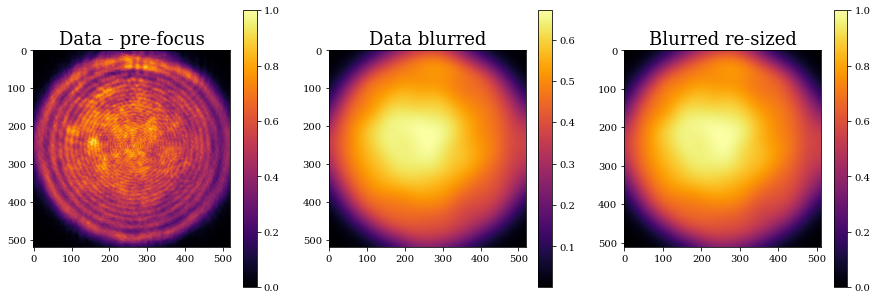

In [3]:
# fname = data_dir + "intensity/15_07_intensity_image_test.png"
# data = imread(fname, as_gray=True) 
# data= np.flip(data) # det saves images fliiped upside down
# manual_lim = [1363,4203,386,3214]
# data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
# data = (data - data.min())/(data.max()-data.min())

intensity_dist = np.load(data_dir+"spider/11_11_2024/RHCP_intensity_img_80us_0gain_img_stack_batch_0.npy")[0,:]
intensity_dist = np.flipud(intensity_dist)

manual_cen = [2035,2625] # [row, col]
hlf_sz = 260       
intensity_dist = intensity_dist[manual_cen[0]-hlf_sz:manual_cen[0]+hlf_sz, manual_cen[1]-hlf_sz:manual_cen[1]+hlf_sz]
intensity_dist = 0 + (1-0)/(intensity_dist.max()- intensity_dist.min())*(intensity_dist - intensity_dist.min())

# blurred = ski.filters.gaussian(data, sigma=(120, 120))
blurred = ski.filters.gaussian(intensity_dist, sigma=(30, 30))


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(intensity_dist)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


In [4]:
# Create dLux class for this gauss transmissive layer
# maybe modelling a source object would be easier?
class GaussTransmissiveLayer(dl.layers.optical_layers.TransmissiveLayer):
    """
        Inherits from dl.layers.TransmissiveLayer and allows for
        a Gaussian transmissive layer to be simulated. Useful for 
        simulating a wavefront that is not uniform in intensity.

        Attributes
        ----------
        transmission: Array
            The Array of transmission values to be applied to the input wavefront.
        gaussian_param: Array = [var_x, var_y], shape (2,)
            The parameters defining the 2D Gaussian to be applied to the input wavefront.
            Where:
            var_x, var_y = float
                Variance in the x and y directions (m)
            Center of Gaussian is given by position of Pointsource
        pixel_coords : Array
            3D array of pixel coordinates over which gaussian is defined in the shape
            (2, npix, npix) where npix is the number of pixels across one dimension of the
            each 2D array (one for X and Y).
        det_npix: int
            Number of pixels across the detector.
        psf_pixel_scale: float
            Pixel scale of the detector (arcsec/px).
        normalise: bool
            Whether to normalise the wavefront after passing through the optic.
    """
    X: jnp.array
    Y: jnp.array

    gauss_param: jnp.array
    point_source: dl.PointSources
    det_npix: int
    pp_npix: int # pupil-plane pixel size
    psf_pixel_scale: float
    pixel_size: float

    def __init__(
        self: dl.layers.optical_layers.OpticalLayer,
        point_source: dl.PointSources,
        gaussian_param: jnp.array,
        pixel_coords: jnp.array,
        det_npix: int,
        psf_pixel_scale: float,
        normalise: bool = False,
    ):
        self.X, self.Y = pixel_coords
        assert gaussian_param.shape == (2,), "Gaussian parameters must be of shape (2,) in form [var_x, var_y] "
        self.pp_npix = self.X.shape[0]
        self.gauss_param = gaussian_param
        self.point_source = point_source

        self.det_npix = det_npix
        self.psf_pixel_scale = psf_pixel_scale
        self.pixel_size = jnp.abs(pixel_coords[0,0,1] - pixel_coords[0,0,0]) #distance between adjacent px

        trans = self.get_transmission()

        super().__init__(transmission=trans, normalise=normalise)

    def get_transmission(self):
        # angular position to number of pixels across detector
        pos = self.point_source.position[0]
        x_0_px = dlu.rad2arcsec(pos[0]) / self.psf_pixel_scale 
        y_0_px = dlu.rad2arcsec(pos[1]) / self.psf_pixel_scale 

        # convert to number of pixels across pupil plane
        x_0_px *= self.pp_npix / self.det_npix
        y_0_px *= self.pp_npix / self.det_npix 

        # convert to linear distance (m) across pupil plane
        x_0 = x_0_px*self.pixel_size
        y_0 = y_0_px*self.pixel_size

        # x_0 *= -1 #dLux conventions or Positon
        # y_0 *= -1

        z = jnp.exp(-(self.X - x_0)**2/(2*self.gauss_param[0]**2) - (self.Y - y_0)**2/(2*self.gauss_param[1]**2))

        return z 

    def apply(self: dl.layers.optical_layers.OpticalLayer, wavefront: dl.wavefronts.Wavefront) -> dl.wavefronts.Wavefront:
        """
        Applies the layer to the wavefront.

        Parameters
        ----------
        wavefront : Wavefront
            The wavefront to operate on.

        Returns
        -------
        wavefront : Wavefront
            The transformed wavefront.
        """
        wavefront *= self.get_transmission()
        if self.normalise:
            wavefront = wavefront.normalise()
        return wavefront


In [5]:
# Define non-linear detector response
class ApplyBFSPixelResponse(dl.layers.detector_layers.DetectorLayer):
    """
    Applies a pixel response array to the input psf, via a multiplication. This can be
    used to model variations in the inter and intra-pixel sensitivity variations common
    to most detectors.

    We have characterised the BFS detector to have a gamma curve gain response per px.

    ??? abstract "UML"
        ![UML](../../assets/uml/ApplyPixelResponse.png)

    Attributes
    ----------
    pixel_response : Array
        The pixel_response to apply to the input psf in the form of gamma fn coeffs:
        measured_intensity = alpha + beta*real_intensity^gamma
        with    pixel_response[0] = alpha
                pixel_response[1] = beta
                pixel_response[2] = gamma
    luminance_min, luminance_max : float
        The minimum and maximum input luminance values for the pixel response (with which the 
        gamma curve was characterised).
    intensity_min, intensity_max : float
        The minimum and maximum output intensity values for the pixel response (with which the 
        gamma curve was characterised).
    """

    pixel_response: jnp.array
    x_intercepts: jnp.array
    # luminance_min: float
    # luminance_max: float
    # intensity_min: float
    # intensity_max: jnp.float64

    def __init__(self: dl.layers.detector_layers.DetectorLayer, 
                 pixel_response: jnp.array,
                # luminance_min: float,
                # luminance_max: float,
                # intensity_min: float,
                # intensity_max: float,
                 ):
        """
        Parameters
        ----------
        pixel_response : Array
            The pixel_response to apply to the input psf. Must be a 2-dimensional array
            equal to size of the psf at time of application.
        """
        super().__init__()
        # assert pixel_response.shape[0] == 3, "Pixel response must contain 3 matrices corresponding to gamma fn coeffs"
        # assert luminance_max > luminance_min, "luminance_max must be greater than luminance_min"
        # assert intensity_max > intensity_min, "intensity_max must be greater than intensity_min"

        self.pixel_response = jnp.asarray(pixel_response, dtype=float)
        self.x_intercepts = self.calc_x_intercepts()
        # self.luminance_min = jnp.array(luminance_min, dtype=float)
        # self.luminance_max = jnp.array(luminance_max, dtype=float)
        # self.intensity_min = jnp.array(intensity_min, dtype=float)
        # self.intensity_max = jnp.array(intensity_max, dtype=float)

    def calc_x_intercepts(self):
        """
            Calculate the x-intercepts of the gamma function, for input intensity values
            that result in curve below x-axis. Think this is just a precision artefact.
        """
        x_int = jnp.power((-self.pixel_response[0] / self.pixel_response[1]), 1/self.pixel_response[2])
        
        return x_int


    def apply(self: dl.layers.detector_layers.DetectorLayer, psf: dl.PSF) -> dl.PSF:
        """
        Applies the layer to the PSF.

        Parameters
        ----------
        psf : PSF
            The psf to operate on.

        Returns
        -------
        psf : PSF
            The transformed psf.

        """
        psf_array = jnp.asarray(psf.data, dtype=float)
        # # assert psf_array.shape == self.pixel_response[0].shape and\
        # # psf_array.shape == self.pixel_response[1].shape and \
        # # psf_array.shape == self.pixel_response[2].shape, "PSF and pixel response must have same shape"

        # # remap to [luminance_min, luminance_max] for measured gamma fn 
        # orig_min, orig_max = psf_array.min(), psf_array.max()
        # # print(orig_min, orig_max)
        # # data_remapped = psf_array #0.0 + ((1.0 - 0.0)/(orig_max-orig_min))*(psf_array - orig_min)

        # # # t1 = jnp.isnan(orig_max-orig_min)
        # # # t2 = jnp.isnan(psf_array - orig_min)
        # # # print(t1.sum(), t2.sum())
        # # # print("data remapped max and min:", data_remapped.max(), data_remapped.min())

        # power = psf_array**self.pixel_response[2] # think jnp.power() is causing nan grads
        # measured_psf = self.pixel_response[0] + self.pixel_response[1]*power #element-wise power

        # # neg_mask = measured_psf < 0.0
        # # measured_psf = measured_psf*jnp.invert(neg_mask) + psf_array*neg_mask # take orig values if neg


        # # print("coeffs: {}, {},{}, input intensity: {} output intensity: {}".format(self.pixel_response[0][0,0],self.pixel_response[1][0,0],self.pixel_response[2][0,0], psf_array[0,0], measured_psf[0,0]))
        
        # # # for some reason this is not guaranteed to be in the range of [intensity_min, intensity_max]?? fns calc should be in range
        # # # either interpet this as 0 pixel or remap range? 
        # # Because of floating point precision limitations - very small values show curve below x-axis. Remap to fix this.
        # measured_psf = orig_min+ ((1.0 - orig_min)/(measured_psf.max()-measured_psf.min()))*(measured_psf - measured_psf.min())
        # # # print(measured_psf.max(), measured_psf.min())

        # # # print(self.pixel_response[0][0,0],self.pixel_response[1][0,0],self.pixel_response[2][0,0])
        # # # reamap back to original range (in range of [intensity_min, intensity_max] currently)
        # # measured_psf = orig_min + ((orig_max - orig_min)/(1.0 - 0.0))*(measured_psf - 0.0)

        # # # psf_obj = dl.PSF(data = data_remapped, pixel_scale = psf.pixel_scale)
        # # measured_psf = measured_psf.at[measured_psf < 0.0].set(0.0001)
        # # psf_obj = dl.PSF(data = jnp.abs(measured_psf), pixel_scale = psf.pixel_scale)
        # psf_obj = dl.PSF(data = (measured_psf), pixel_scale = psf.pixel_scale)


        psf_obj = dl.PSF(data = psf_array**(1/1), pixel_scale = psf.pixel_scale)


        return psf_obj


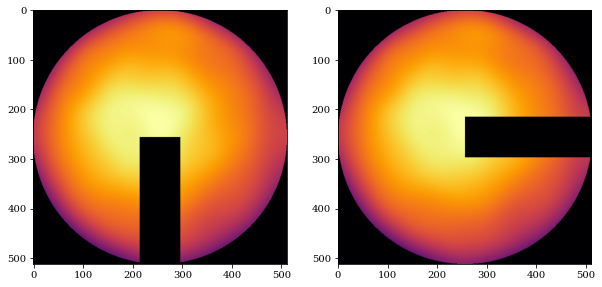

In [4]:
# Zernike aberrations
zernike_indicies = jnp.arange(4, 15) # up to 10th noll idxs (excluding piston)
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

# Using PointSources instead of single PointSource object to overcome float grad issue when solving for flux
red_src = dl.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

spider_angles = [180, 270] # 0deg is spider pointing vertically up (if looking at 'lower' origin), rotates CW from 0deg
optical_systems = []
transmissions = []
for i in range(len(spider_angles)):
    spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angles[i]])
    transmission = dlu.combine([circle, spider])*intensity_dist

    layers = [
        ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False)),
    ]

    optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

    optical_systems.append(optics)
    transmissions.append(transmission)

# Construct Optics
optics_sp270  = optical_systems[1]
optics_sp180 = optical_systems[0]
sp270_trans = transmissions[1]
sp180_trans = transmissions[0]

plt.subplot(1,2,1)
plt.imshow(sp180_trans)
plt.subplot(1,2,2)
plt.imshow(sp270_trans)
# ----------------------------------------------------------------------------------#
# # Create detector layer to characterise non-linear response of BFS det 
# row_start, col_start = 1676, 2532 # Start coord of window on det where data was taken
# row_len, col_len = 86, 76   # window size of recorded data
# psf_hlf_sz = 14             # half window sz of cropped data

# # load in response curve matrices (form of Gamma fn)
# alpha = np.load("data/80us_detector/ALPHA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]
# beta = np.load("data/80us_detector/BETA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]
# gamma = np.load("data/80us_detector/GAMMA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]

# # Crop, anchored on middle (cropped data will be based on max values, but this occurs close enough to the
# # middle to estimate here. + detector response is fairly homogenous over small window)
# middle_row, middle_col = int(alpha.shape[0]/2), int(alpha.shape[1]/2)
# cropped_alpha = alpha[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]
# cropped_beta = beta[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]
# cropped_gamma = gamma[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]

# pixel_response = jnp.array([cropped_alpha, cropped_beta, cropped_gamma])
# detector = dl.LayeredDetector([ApplyBFSPixelResponse(pixel_response=pixel_response)])


Loss fn's

In [5]:
params = [
    'aperture.coefficients',
    'source.position',
    'source.flux', 
    ]
optimisers = [
            optax.adam(learning_rate=1e-9),
            optax.adam(learning_rate=1e-8),
            optax.adam(learning_rate=1e6),
              ]
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_gaussian(model, data):

    simu_psf = model.model()

    uncertainty = 0.1 # 10% err per pix TODO try increasing

    loss = -jsp.stats.norm.logpdf(x=simu_psf, loc=data, scale=data*uncertainty).sum()

    return loss
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss

Lets loop this

Fit on both models simultaneously (taking avg gradient from likelihood fn), using ~30 frames to get avgs of coeffs, with mean as SEMS.

In [6]:
# Location on detector 
row_start, col_start = 1640, 2576 # Start coord of window on det where data was taken
row_len, col_len = 442, 480   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

img_fnames = [
    "spider/11_11_2024/RHCP_red_0deg_img_80us_0gain_img_stack_batch_0.npy",
    "spider/11_11_2024/RHCP_red_90deg_img_80us_0gain_img_stack_batch_0.npy",
]
labels = [
    "0deg",
    "90deg",
]

bckgnd_fnames = [
    # "16_09_0deg_bckgnd_133us_0gain_img_stack_batch_0.npy",
    # "16_09_90deg_bckgnd_138us_0gain_img_stack_batch_0.npy",
]

imgs = np.asarray([np.flipud(np.load(data_dir+img_fname)) for img_fname in img_fnames])

bckgnds = np.asarray([np.mean(np.flipud(np.load(data_dir+bckgnd_fname))) for bckgnd_fname in bckgnd_fnames])  # single bckgnd frame avg'd

n_frames = 30   #number of frames to perform phase retrieval on
step_sz = int(imgs[0].shape[0]/n_frames) # step size for frames (equally spaced frame grabs)
print(imgs[0].shape)


(50, 442, 480)


In [7]:
# Store final loss and coefficients for each frame, for each configuration : [0, 90, combined]
final_loss_configs = [[], [], []]
retrieved_coeffs_configs = [[], [], []]
final_pos_configs = [[], [], []]
final_flux_configs = [[], [], []]
frames = []

dir_ = "data/spider/retrieval_results/" # save png's of phase retrieval results
dir_configs = [dir_ + "0deg/", dir_ + "90deg/", dir_ + "combined/"]

for i in range(n_frames):
    ###---------------------------- Re-init models ----------------------------###
    instrument_sp180 = dl.Telescope(optics_sp180, ('source', red_src))
    instrument_sp270 = dl.Telescope(optics_sp270, ('source', red_src))

    sim_psfs = [instrument_sp180.model(), instrument_sp270.model()]
    norm_psfs = [PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min()) for sim_psf in sim_psfs]    

    ###------------------------------- Get Frame -----------------------------###
    frame_n = i*step_sz-1 if i != 0 else 0
    frames.append(frame_n)
    data_sp180 = imgs[0][frame_n,:,:] # assuming only two spider configs, given in order of increasing angle
    data_sp270 = imgs[1][frame_n,:,:]
    data_list = [data_sp180, data_sp270]
    scaled_data_list = []
    for j in range(len(data_list)):
        data = data_list[j]
        if len(bckgnds) > 0:
            data = data - bckgnds[j]

        # Reverse-model detector response
        data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
        data = np.power((data_remapped-np.flipud(alpha_cropped))/np.flipud(beta_cropped), (1/np.flipud(gamma_cropped))) # flip vertically

        # Scale intensity
        current_range = data.max() - data.min()
        new_range = sim_psfs[j].max() - sim_psfs[j].min()
        scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psfs[j].min()

        psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
        scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                    psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
        
        scaled_data_list.append(scaled_data)


    ###------------------------------- Phase Retrieval -----------------------------###
    configs = [instrument_sp180, instrument_sp270] # model configurations to optimise upon

    # # Solve for individual configs firstly 
    # for k, instrument in enumerate(configs):
    #     scaled_data = scaled_data_list[k]

    #     optim, opt_state = zdx.get_optimiser(instrument, params, optimisers)

    #     progress_bar = tqdm(range(5000), desc='Loss: ')

    #     # Run optimisation loop 
    #     net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    #     for j in progress_bar:
    #         poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

    #         updates, opt_state = optim.update(poiss_grads, opt_state)
    #         instrument = zdx.apply_updates(instrument, updates) 

    #         net_losses.append(poiss_loss)
    #         Fluxes.append(instrument.source.flux)
    #         Coeffs.append(instrument.aperture.coefficients)
    #         Positions.append(instrument.source.position)

    #         progress_bar.set_postfix({'Loss': poiss_loss, 'Frame': frame_n})

    #     final_loss_configs[k].append(net_losses[-1])
    #     retrieved_coeffs_configs[k].append(instrument.aperture.coefficients)
    #     final_pos_configs[k].append(instrument.source.position[0])
    #     final_flux_configs[k].append(instrument.source.flux[0])


    #     ###---------------------------------- Plotting ---------------------------------###
    #     plt.figure(figsize=(6,12))
    #     plt.subplot(4,2,1)
    #     plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    #     plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    #     plt.title("Position")
    #     plt.legend()
    #     plt.subplot(4,2,2)
    #     arr_coeffs = np.asarray(Coeffs)
    #     for l in range(len(Coeffs[0])):
    #         label = "Coeff " + str(zernike_indicies[l])
    #         plt.plot(arr_coeffs[:,l], label=label)
    #     plt.legend()
    #     plt.subplot(4,2,3)
    #     plt.plot(np.asarray(Fluxes))
    #     plt.title("Flux")
    #     plt.subplot(4,2,4)
    #     plt.plot(np.array(net_losses))
    #     ax = plt.gca()
    #     ax.set_title("Training History")
    #     ax.set_xlabel("Training Epoch")
    #     ax.set_ylabel("Poisson Log-Likelihood")


    #     plt.subplot(4,2,5)
    #     norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    #     plt.imshow(scaled_data, norm=norm_psf)
    #     plt.colorbar()
    #     plt.title('Data')

    #     plt.subplot(4,2,6)
    #     model_psf = instrument.model()
    #     current_range = model_psf.max() - model_psf.min()
    #     new_range = scaled_data.max() - scaled_data.min()
    #     model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    #     norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    #     mask = np.ones(scaled_data.shape)
    #     mask[scaled_data < 0.01] = 0
    #     plt.imshow(model_psf*mask, norm=norm_psf)
    #     plt.title('Model')
    #     plt.colorbar()

    #     plt.subplot(4,2,7)
    #     resid = scaled_data - model_psf
    #     plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    #     plt.colorbar()
    #     plt.title('Residuals')

    #     plt.subplot(4,2,8)
    #     opd = instrument.aperture.eval_basis()
    #     trans = instrument.aperture.transmission
    #     plt.imshow(opd*trans, cmap='viridis')
    #     plt.title('Retrieved Aberrations')
    #     plt.colorbar()
    #     plt.tight_layout()

    #     plt.savefig(dir_configs[k] + "frame_" + str(frame_n) + ".png")
    #     plt.close()


    # -------------------------- Combined Configurations --------------------------#
    # Now repeat for simultaneous solving between spider configs
    # Pick either config here, all that matters is that they have the same coeff initialisation and structure
    optim, opt_state = zdx.get_optimiser(instrument_sp180, params, optimisers)

    progress_bar = tqdm(range(1500), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions_sp180, Positions_sp270, Fluxes= [],[],[],[],[]
    for j in progress_bar:
        grads = None
        net_loss = 0
        mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
        pos_grads = [] # update positional gradients separately (right now I've centered data based on brightest pixel
                        # but this is not a super robust method, so allow for source position difference)
        for k in range(len(configs)):
            loss, grads = loss_fn_poisson(model = configs[k], data = scaled_data_list[k])
            net_loss += loss 
            
            if k == 0:
                mean_coeff_grads = grads.aperture.coefficients/len(configs)
                mean_position_grads = grads.source.position/len(configs)
                mean_flux_grads = grads.source.flux/len(configs)
            else:
                mean_coeff_grads += grads.aperture.coefficients/len(configs)
                mean_position_grads += grads.source.position/len(configs)
                mean_flux_grads += grads.source.flux/len(configs)

            pos_grads.append(grads.source.position)

        grads = grads.set('aperture.coefficients', mean_coeff_grads)
        grads = grads.set('source.position', mean_position_grads)
        grads = grads.set('source.flux', mean_flux_grads)

        for k in range(len(configs)):
            grads = grads.set('source.position', pos_grads[k])
            updates, opt_state = optim.update(grads, opt_state)
            configs[k] = zdx.apply_updates(configs[k], updates)

        net_losses.append(net_loss)
        Fluxes.append(configs[0].source.flux)
        Coeffs.append(configs[0].aperture.coefficients)
        Positions_sp180.append(configs[0].source.position)
        Positions_sp270.append(configs[1].source.position)

        progress_bar.set_postfix({'Loss (combined)': net_loss, 'Frame': frame_n})

    final_loss_configs[-1].append(net_losses[-1])
    retrieved_coeffs_configs[-1].append(configs[0].aperture.coefficients)
    final_pos_configs[-1].append(configs[0].source.position[0])
    final_flux_configs[-1].append(configs[0].source.flux[0])


    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(10,12))
    plt.subplot(4,3,1)
    plt.plot(np.asarray(Positions_sp180)[:,0,0], label="Position X - sp180")
    plt.plot(np.asarray(Positions_sp180)[:,0,1], label="Position Y - sp180")
    plt.plot(np.asarray(Positions_sp270)[:,0,0], label="Position X - sp270")
    plt.plot(np.asarray(Positions_sp270)[:,0,1], label="Position Y - sp270")
    plt.title("Position")
    plt.legend()
    plt.subplot(4,3,2)
    arr_coeffs = np.asarray(Coeffs)
    for l in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[l])
        plt.plot(arr_coeffs[:,l], label=label)
    plt.legend()
    plt.subplot(4,3,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(4,3,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")

    it = 5
    for k, config in enumerate(configs):
        plt.subplot(4,3,it)
        opd = config.aperture.eval_basis()
        trans = config.aperture.transmission
        plt.imshow(opd*trans, cmap='viridis')
        plt.title('Retrieved Aberrations')
        plt.colorbar()
        it+=1

    for k, config in enumerate(configs):
        scaled_data = scaled_data_list[k]
        instrument = config

        plt.subplot(4,3,it)
        norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
        plt.imshow(scaled_data, norm=norm_psf)
        plt.colorbar()
        plt.title('Data')
        it+=1

        plt.subplot(4,3,it)
        model_psf = instrument.model()
        current_range = model_psf.max() - model_psf.min()
        new_range = scaled_data.max() - scaled_data.min()
        model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
        norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
        mask = np.ones(scaled_data.shape)
        mask[scaled_data < 0.01] = 0
        plt.imshow(model_psf*mask, norm=norm_psf)
        plt.title('Model')
        plt.colorbar()
        it+=1

        plt.subplot(4,3,it)
        resid = scaled_data - model_psf
        plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
        plt.colorbar()
        plt.title('Residuals')
        it+=1

    plt.savefig(dir_configs[-1] + "frame_" + str(frame_n) + ".png")
    plt.close()

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

Loss:   0%|          | 0/1500 [00:00<?, ?it/s]

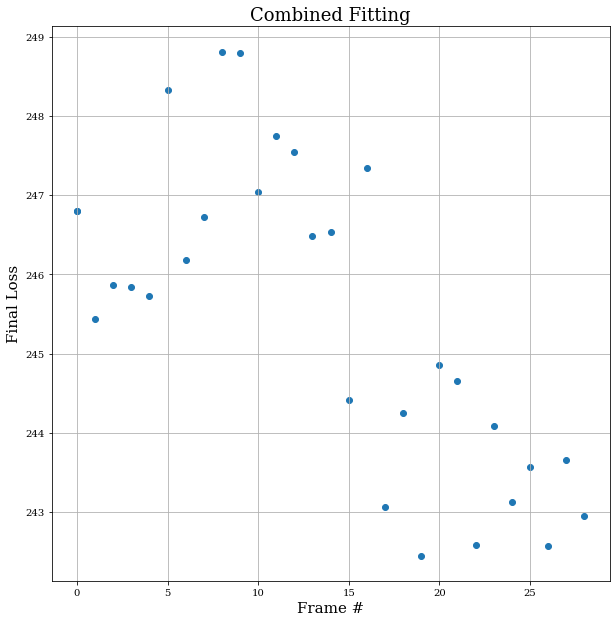

In [8]:
# See how well phase retrieval performed and only avg across "succcessful" retrievals
# config_labels = ['0deg', '90deg', 'combined']
# plt.figure(figsize=(15,5))
# for i, final_loss in enumerate(final_loss_configs):
#     plt.subplot(1,3,i+1)
#     plt.scatter(frames, final_loss)
#     plt.title(config_labels[i])
#     plt.xlabel("Frame #")
#     plt.ylabel("Final Loss")
#     plt.grid()

plt.scatter(frames, final_loss_configs[-1])
plt.title('Combined Fitting')
plt.xlabel("Frame #")
plt.ylabel("Final Loss")
plt.grid()

# Threshold picked by eye

#### Summary statistics ✨

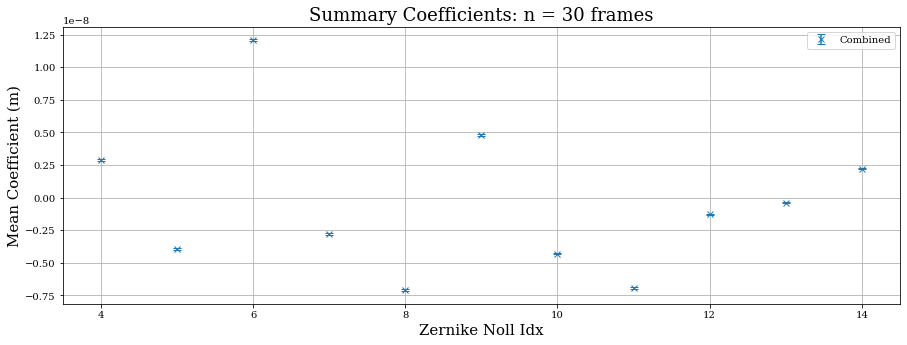

In [9]:
# For all 3 scenarios
# retrieved_coeffs_configs = np.asarray(retrieved_coeffs_configs)
# mean_coeffs_configs = np.mean(retrieved_coeffs_configs, axis=1)
# print(mean_coeffs_configs.shape)
# stdev = np.std(retrieved_coeffs_configs, axis=1)
# SEMs = stdev/np.sqrt(n_frames)

# fmt_markers = ['.','*','x']
# plt.figure(figsize=(10,5))
# for i, mean_coeffs_config in enumerate(mean_coeffs_configs):
#     plt.errorbar(zernike_indicies, mean_coeffs_config, yerr=SEMs[i], fmt=fmt_markers[i], capsize=4, label=config_labels[i])

# plt.title("Summary Coefficients: n = " + str(n_frames)+ " frames")
# plt.xlabel("Zernike Noll Idx")
# plt.ylabel("Mean Coefficient (m)")
# plt.grid()
# plt.legend()

# For just combined fits
retrieved_coeffs_configs_arr = np.asarray(retrieved_coeffs_configs[-1])
mean_coeffs_configs = np.mean(retrieved_coeffs_configs_arr, axis=0)
stdev = np.std(retrieved_coeffs_configs_arr, axis=0)
SEMs = stdev/np.sqrt(n_frames)

plt.figure(figsize=(15,5))
plt.errorbar(zernike_indicies, mean_coeffs_configs, yerr=SEMs, fmt='x', capsize=4, label="Combined")
plt.title("Summary Coefficients: n = " + str(n_frames)+ " frames")
plt.xlabel("Zernike Noll Idx")
plt.ylabel("Mean Coefficient (m)")
plt.grid()
plt.legend()


In [10]:
# Store (combined)
spider_coeff_dir = "data/spider/retrieval_results/"

# np.save(spider_coeff_dir + "mean_coeffs_0deg.npy", mean_coeffs_configs[0])
# np.save(spider_coeff_dir + "mean_coeffs_90deg.npy", mean_coeffs_configs[1])
# np.save(spider_coeff_dir + "mean_coeffs_combined.npy", mean_coeffs_configs[2])

# np.save(spider_coeff_dir + "SEM_coeffs_0deg.npy", SEMs[0])
# np.save(spider_coeff_dir + "SEM_coeffs_90deg.npy", SEMs[1])
# np.save(spider_coeff_dir + "SEM_coeffs_combined.npy", SEMs[2])

np.save(spider_coeff_dir + "11_11_mean_coeffs_combined.npy", mean_coeffs_configs)
# np.save(spider_coeff_dir + "01_08_90180_SEM_coeffs_combined.npy", SEMs)


In [11]:
print(mean_coeffs_configs)

[ 2.89585739e-09 -3.95500919e-09  1.20750780e-08 -2.77219038e-09
 -7.09704327e-09  4.77169970e-09 -4.29659264e-09 -6.93444662e-09
 -1.26191466e-09 -3.92156436e-10  2.22673074e-09]


#### Fisher Info - Variance min 

In [ ]:
# Check error bars with fisher info - covariance matrix diag  gives us the lower bound on the variance 
# of the corresponding parameters. This should be evaluated with parameters corresponding to the 
# maximum likelihood (i.e. after optimisation).

# # 1. Get optimal parameters
# # Based on mean fits
# mean_pos_configs =  np.mean(final_pos_configs, axis=1)
# mean_flux_configs =   np.mean(final_flux_configs, axis=1)
# final_models = [dl.Telescope(optics_sp180, ('source', red_src)),
#                 dl.Telescope(optics_sp270, ('source', red_src)),
#                 dl.Telescope(optics_sp180, ('source', red_src)),
#                 ]
# np.save(spider_coeff_dir + "final_model_mean_pos.npy", mean_pos_configs)
# np.save(spider_coeff_dir + "final_model_mean_flux.npy", mean_flux_configs)


# for i, mean_coeffs in enumerate(mean_coeffs_configs):
#     final_models[i] = final_models[i].set('aperture.coefficients', mean_coeffs)
#     final_models[i] = final_models[i].set('source.position', np.asarray([mean_pos_configs[i]]))
#     final_models[i] = final_models[i].set('source.flux', np.asarray([mean_flux_configs[i]]))
    
# # 2. Calc covariance matrix
# fisher_stdevs = []
# for model in final_models:
#     cov = zdx.self_covariance_matrix(model, "aperture.coefficients", zdx.bayes.poiss_loglike)
#     print("Fisher info var: sqrt(Diag)/N_frames: {}".format((np.diag(cov)**0.5)/n_frames))

#     fisher_stdevs.append((np.diag(cov)**0.5)/n_frames)
# # 1. Get optimal parameters
# Based on mean fits
mean_pos_configs =  np.mean(final_pos_configs[-1], axis=0)
mean_flux_configs =   np.mean(final_flux_configs[-1], axis=0)
final_model = dl.Telescope(optics_sp180, ('source', red_src))

np.save(spider_coeff_dir + "final_model_mean_pos.npy", mean_pos_configs)
np.save(spider_coeff_dir + "final_model_mean_flux.npy", mean_flux_configs)

final_model = final_model.set('aperture.coefficients', mean_coeffs_configs)
final_model = final_model.set('source.position', np.asarray([mean_pos_configs]))
final_model = final_model.set('source.flux', np.asarray([mean_flux_configs]))
    
# 2. Calc covariance matrix
cov = zdx.self_covariance_matrix(final_model, "aperture.coefficients", zdx.bayes.poiss_loglike)
print("Fisher info var: sqrt(Diag)/N_frames: {}".format((np.diag(cov)**0.5)/n_frames))

fisher_stdevs = (np.diag(cov)**0.5)/n_frames



The CRLB is slightly larger than our calculated uncertainties. Lets use this theoretical limit instead.

In [ ]:
fmt_markers = ['.','*','x']
# plt.figure(figsize=(10,5))
# for i, mean_coeffs_config in enumerate(mean_coeffs_configs):
#     plt.errorbar(zernike_indicies, mean_coeffs_config, yerr=fisher_stdevs[i], fmt=fmt_markers[i], capsize=4, label=config_labels[i])

# plt.title("Summary Coefficients: n = " + str(n_frames)+ " frames")
# plt.xlabel("Zernike Noll Idx")
# plt.ylabel("Mean Coefficient (m)")
# plt.grid()
# plt.legend()

plt.figure(figsize=(10,5))
plt.errorbar(zernike_indicies, mean_coeffs_configs, yerr=fisher_stdevs, fmt=fmt_markers[0], capsize=4, label="Combined")
plt.title("Summary Coefficients: n = " + str(n_frames)+ " frames")
plt.xlabel("Zernike Noll Idx")
plt.ylabel("Mean Coefficient (m)")
plt.grid()
plt.legend()